<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Author**: **Tewabe** **Melkamu**

Date: 3/10/2025

LST_Data Collection


In [4]:
import ee
import folium
import matplotlib.pyplot as plt
import geemap
import math
# Authenticate to Earth Engine. This will open a browser window.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-melkatewabe')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Data** **spacification** **and** **visualization**




In [3]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
# Using the USDOS/LSIB_SIMPLE/2017 dataset.
# If Taiwan is not available in this dataset, consider an alternative source.
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load ESA WorldCover and create a mask
# -------------------------------------------------------------------
# Load the first image from ESA WorldCover and clip it to Taiwan.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)
# Class definitions from ESA WorldCover:
# 50 = Built-up, 80 = Permanent water bodies.
# We remove both built-up and permanent water by keeping pixels that are not 50 and not 80.
mask = worldcover.neq(50).And(worldcover.neq(80))

# Create an interactive map (optional).
#Map = geemap.Map(center=[23.5, 121], zoom=7)

# -------------------------------------------------------------------
# 3. Loop through each year from 2004 to 2024 and export the yearly mean LST
# -------------------------------------------------------------------
for year in range(2004, 2025):
    print(f"Processing year: {year}")

    # Define the date range for the year.
    start_date = ee.Date(f'{year}-01-01')
    end_date = ee.Date(f'{year}-12-31')

    # Compute the mean LST image for the year using the MODIS LST (MODIS/061/MOD11A1).
    modisLST = (ee.ImageCollection("MODIS/061/MOD11A1")
                .filterDate(start_date, end_date)
                .filterBounds(taiwan)
                .select('LST_Day_1km')
                .mean()
                .clip(taiwan))

    # Multiply by 0.02 to convert the raw values to Kelvin.
    modisLST_K = modisLST.multiply(0.02)

    # Apply the mask.
    modisLST_masked = modisLST_K.updateMask(mask)

    # Optional: Add layers to the map for visualization.
    #Map.addLayer(modisLST_K, {'min': 280, 'max': 315, 'palette': ['blue', 'green', 'red']}, f'MODIS LST {year} (K)')
    #Map.addLayer(modisLST_masked, {'min': 280, 'max': 315, 'palette': ['blue', 'green', 'red']}, f'LST Masked {year}')

    # Define and start the export task.
    task = ee.batch.Export.image.toDrive(
        image=modisLST_masked,
        description=f'LST_{year}',
        folder='Taiwan_LST',  # Update this to your desired Drive folder.
        fileNamePrefix=f'LST_{year}',
        region=taiwan.geometry().bounds().getInfo()['coordinates'],
        scale=1000,  # MODIS resolution is approximately 1 km.
        crs='EPSG:32651',
        maxPixels=1e13
    )
    task.start()
    print(f"Export task for {year} started. Please check your GEE tasks and Google Drive.")

# Optionally, display the interactive map.
#Map


Processing year: 2004
Export task for 2004 started. Please check your GEE tasks and Google Drive.
Processing year: 2005
Export task for 2005 started. Please check your GEE tasks and Google Drive.
Processing year: 2006
Export task for 2006 started. Please check your GEE tasks and Google Drive.
Processing year: 2007
Export task for 2007 started. Please check your GEE tasks and Google Drive.
Processing year: 2008
Export task for 2008 started. Please check your GEE tasks and Google Drive.
Processing year: 2009
Export task for 2009 started. Please check your GEE tasks and Google Drive.
Processing year: 2010
Export task for 2010 started. Please check your GEE tasks and Google Drive.
Processing year: 2011
Export task for 2011 started. Please check your GEE tasks and Google Drive.
Processing year: 2012
Export task for 2012 started. Please check your GEE tasks and Google Drive.
Processing year: 2013
Export task for 2013 started. Please check your GEE tasks and Google Drive.
Processing year: 201

# One year data

In [5]:
# -------------------------------------------------------------------
# 1. Define the study region (Taiwan)
# -------------------------------------------------------------------
gaul = ee.FeatureCollection("FAO/GAUL/2015/level0")
taiwan = gaul.filter(ee.Filter.eq('ADM0_NAME', 'Taiwan'))

# -------------------------------------------------------------------
# 2. Load MODIS LST and compute a composite
# -------------------------------------------------------------------
# Using MODIS/006/MOD11A1 (Terra LST, 1 km resolution)
# The "LST_Day_1km" band has a scale factor of 0.02 (in Kelvin)
modisLST = (ee.ImageCollection("MODIS/061/MOD11A1")
            .filterDate('2024-01-01', '2024-12-31')
            .filterBounds(taiwan)
            .select('LST_Day_1km')
            .mean()
            .clip(taiwan))

# Multiply by 0.02 to convert the raw values to Kelvin.
modisLST_K = modisLST.multiply(0.02)

# -------------------------------------------------------------------
# 3. Create a mask for water bodies and urban area
# -------------------------------------------------------------------
# Load ESA WorldCover and clip to Ethiopia.
worldcover = ee.ImageCollection("ESA/WorldCover/v200").first().clip(taiwan)

# Class definitions from ESA WorldCover:
# 50 = Built-up
# 80 = Permanent water bodies
# We keep only pixels that are NOT 50 and NOT 80.
mask = worldcover.neq(80)

# Apply the mask to the LST image (which is in Kelvin).
modisLST_masked = modisLST_K.updateMask(mask)

# -------------------------------------------------------------------
# 4. Visualize the results on the interactive map
# -------------------------------------------------------------------
# Create an interactive map (optional).
Map = geemap.Map(center=[23.5, 121], zoom=7)
# Adjust the visualization range for Kelvin values (e.g., 280K to 315K)
Map.addLayer(modisLST_K, {'min': 280, 'max': 315, 'palette': ['blue', 'green', 'red']}, 'MODIS LST (K)')
Map.addLayer(modisLST_masked, {'min': 280, 'max': 315, 'palette': ['blue', 'green', 'red']}, 'LST - Masked')
Map.addLayer(taiwan , {}, 'Taiwan Boundary')
#Map
# -------------------------------------------------------------------
# 5. Export the masked LST image to Google Drive
# -------------------------------------------------------------------
task = ee.batch.Export.image.toDrive(
    image=modisLST_masked,
    description='LST1_2020',
    folder='GEE_Exports',  # Update this to your desired Drive folder.
    fileNamePrefix='LST1_2020',
    region=taiwan.geometry().bounds().getInfo()['coordinates'],
    scale=1000,  # MODIS resolution is ~1 km.
    crs='EPSG:32651',
    maxPixels=1e13
)
task.start()

print("Export task started. Check your GEE tasks and Google Drive for the exported image.")

Export task started. Check your GEE tasks and Google Drive for the exported image.


In [ ]:
!pip install rasterio

# Data exploring and visualization

Metadata:
driver: GTiff
dtype: float64
nodata: None
width: 282
height: 382
count: 1
crs: EPSG:32651
transform: | 1000.00, 0.00, 118000.00|
| 0.00,-1000.00, 2804000.00|
| 0.00, 0.00, 1.00|


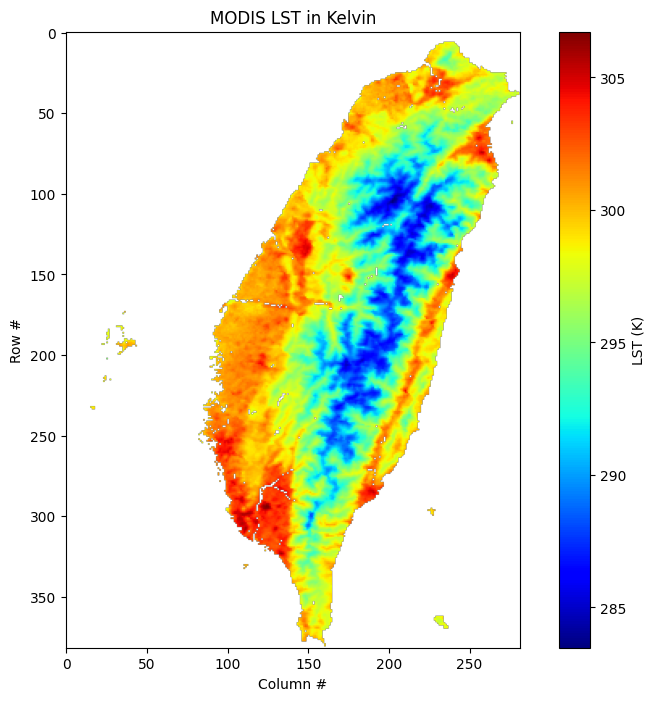

In [6]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Path to the downloaded GeoTIFF file.
filename = '/content/drive/MyDrive/GEE_Exports/LST1_2020.tif'

# Open the file with rasterio
with rasterio.open(filename) as src:
    # Read the first band (assuming the LST is stored in a single band)
    lst_data = src.read(1)
    # Get metadata information
    meta = src.meta
    print("Metadata:")
    for key, value in meta.items():
        print(f"{key}: {value}")

# Mask no-data values (if present)
lst_masked = np.ma.masked_where(lst_data == src.nodata, lst_data)

# Plot the LST image using matplotlib
plt.figure(figsize=(10, 8))
cmap = plt.cm.jet  # choose a colormap
img = plt.imshow(lst_masked, cmap=cmap)
plt.colorbar(img, label='LST (K)')
plt.title('MODIS LST in Kelvin')
plt.xlabel('Column #')
plt.ylabel('Row #')
plt.show()

